# Introduction 

This notebook looks at the amount of comments a pull request received. Both disccusion and code-level comments are analyzed.  

In [1]:
%load_ext autoreload
%autoreload 2

from pymongo import MongoClient
from bson.objectid import ObjectId

mongo_client = MongoClient()

database = mongo_client["graduation"]

pull_requests_collection = database["pull_requests"]

projects_collection = database["projects"]

commits_collection = database["commits"]

In [2]:
import analysis_utilities

#'_id' : {'$lt' : ObjectId("5bca53e00000000000000000")}

projects = list(projects_collection.find({'succeeded' : True, 'travis_is_oldest_ci': True}))

print("Found {} projects with a travis build status date".format(len(projects)))

Found 685 projects with a travis build status date


In [3]:
project_names = []

inline_review_before = []
inline_review_after = []

for project in projects[:10]:
    project_names.append(project["full_name"])
    
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))
    
    prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, True, "status_travis_date")
    
    inline_review_before.append([len(pr["review_comments"]) for pr in prs_before])
    inline_review_after.append([len(pr["review_comments"]) for pr in prs_after])
    

 

/home/nathancassee/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2144: RuntimeWarning: invalid value encountered in greater_equal
  condition = (xf >= v1) & (xf <= v2)
/home/nathancassee/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2144: RuntimeWarning: invalid value encountered in less_equal
  condition = (xf >= v1) & (xf <= v2)


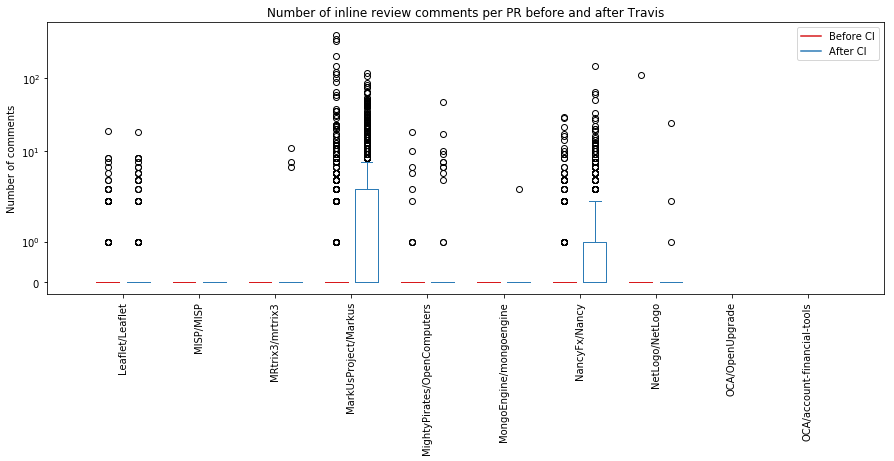

In [4]:
analysis_utilities.do_before_after_boxplot(inline_review_before, inline_review_after, project_names, 
                       'Number of inline review comments per PR before and after Travis',
                       'Number of comments',
                       yscale='symlog')

In [7]:
# This cell exports review data for analysis with R --> This cell 
# results in a single file 'num_of_review_comments.csv' which contains 
# all pull requests that of projects with enough pull requests to 
# analyze

from collections import Counter
import effective_comments.find_effective as eff

import ngramizer

filename = "generated/num_of_review_comments.csv"

import csv
import operator

static_langs = ["C++", "Java", "Objective-C", "C#", "C"]
dynamic_langs = ["Python", "PHP", "JavaScript", "Ruby"] 

with open(filename, mode='w') as num_of_review_comments_file:
    writer = csv.writer(num_of_review_comments_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow([
        'EffectiveComments',
        'TotalReviewComments', 
        'TotalReviewCommentThreads',
        'ShareReviewComments',
        'GeneralComments',
        'GeneralCommentsDiscussingBuild',
        'Additions',
        'Deletions',
        'IsMerged',
        'Commits',
        'Assignees',
        'ChangedFiles',
        'PrOpenedDaysAfterProjectStart',
        'ProjectLanguage',
        'IsAfter',
        'ProjectName',
        'NumOfUniqueUsers',
        'NewContributor',
        'PRsOpened',
        'TotalBuilds',
        'CommitsAfterCreate',
        'AdditionsAfterCreate',
        'DeletionsAfterCreate',
        'LanguageType',
        'FromOutsider'
        ])
    
    for project in projects:
        prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))

        prs = sorted(prs, key=operator.itemgetter("created_at"))
                
        seen_usernames_counter = Counter()
        
        for pr in prs:
            username = pr["user"]["login"]
            
            if project["language"] in static_langs:
                pr["languageType"] = "static"
            elif project["language"] in dynamic_langs:
                pr["languageType"] = "dynamic"
            else:
                pr["languageType"] = "unk"
            
            if username in seen_usernames_counter:
                pr["new_contributor"] = False                
            else:
                pr["new_contributor"] = True    
            
            pr["prs_opened"] = seen_usernames_counter[username]
                
            seen_usernames_counter[username] += 1
            
            builds = 0
            
            additions_after_create = 0
            deletions_after_create = 0
            commits_after_create = 0
            
            for sha in pr["commits"]:
                commit = commits_collection.find_one({"sha":sha})
                
                if len([status for status in commit["statuses"] if status["target_url"] is not None and status["target_url"].startswith("https://travis-ci.org/")]) > 0:
                    builds += 1
                                
                if "date" in commit and commit["date"] > pr["created_at"]:
                    commits_after_create += 1
                    additions_after_create += commit["additions"]
                    deletions_after_create += commit["deletions"]
            
            pr["total_builds"] = builds
            pr["additions_after_create"] = additions_after_create
            pr["deletions_after_create"] = deletions_after_create
            pr["commits_after_create"] = commits_after_create
        
        usernames = []
        
        '''
        Does the unique number of usernames for a project
        '''    
        for pr in prs:

            usernames.append(pr["user"]["login"])

            usernames.extend(ngramizer.given_text_extract_usernames(pr["body"]))

            for comment in pr["raw_comments"]:
                usernames.append(comment["user"]["login"])
                usernames.extend(ngramizer.given_text_extract_usernames(comment["body"]))

        usernames = list(set(usernames))

        project["usernames"] = usernames

        build_terms = ["travi", "continuousintegr", "deploy", "build"]
        
        def does_item_discuss_build(discussion_item, counter):
            for item in counter:
                for term in build_terms:
                    if term in item:
                        discussion_item["discusses_build"] = True
                        return
                    
            discussion_item["discusses_build"] = False

        for pr in prs:
            if False and not ngramizer.is_bot_comment(pr["user"]["login"]):

                counter = Counter()
                linkback = {}

                #ngramizer.add_text_ngrams_to_counter(pr["body"], pr.get("html_url", ""), ngram_length, counter, linkback, project["usernames"])

                does_item_discuss_build(pr, counter)
            else:
                pr["discusses_build"] = False
                
            for comment in pr["raw_comments"]:
                if False and not ngramizer.is_bot_comment(comment["user"]["login"]):
                    counter = Counter()
                    linkback = {}

                    #ngramizer.add_text_ngrams_to_counter(comment["body"], comment.get("html_url", ""), ngram_length, counter, linkback, project["usernames"])
                    
                    does_item_discuss_build(comment, counter)
                else:
                    comment["discusses_build"] = False
        
        prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, True, "status_travis_date")
        
        if len(prs_before) < 100 or len(prs_after) < 100:
            continue
            
        def write_row(pr, is_after):
            project_days_since_pr_start = (pr["created_at"] - project["created_at"]).days
            
            share = 0 if len(pr["raw_comments"]) + len(pr["review_comments"]) == 0 else len(pr["review_comments"]) / (len(pr["review_comments"]) + len(pr["raw_comments"])) * 100 
            
            num_of_unique_users = len(set([cmmnt["user"]["login"] for cmmnt in pr["review_comments"] if cmmnt["user"] is not None] + [cmmnt["user"]["login"] for cmmnt in pr["raw_comments"] if cmmnt["user"] is not None]))
            
            full_commits = list([commits_collection.find_one({'sha': commit_hash}) for commit_hash in pr["commits"]])
            
            hashes = pr["commits"]
            
            pr["commits"] = full_commits
            
            num_of_effective_comments = eff.process_pr(pr)
            
            pr["commits"] = hashes
            
            writer.writerow([
                num_of_effective_comments,
                len(pr["review_comments"]),
                len([rc for rc in pr["review_comments"] if rc["in_reply_to_id"] is None]),
                share,
                len(pr["raw_comments"]),
                len([cmmnt for cmmnt in pr["raw_comments"] if cmmnt["discusses_build"]]),
                pr["additions"],
                pr["deletions"],
                pr["merged"],
                len(pr["commits"]),
                len(pr["assignees"]),
                pr["changed_files"],
                project_days_since_pr_start,
                project["language"],
                is_after,
                project["full_name"],
                num_of_unique_users,
                pr["new_contributor"],
                pr["prs_opened"],
                pr["total_builds"],
                pr["commits_after_create"],
                pr["additions_after_create"],
                pr["deletions_after_create"],
                pr["languageType"],
                pr["from_outsider"]
            ])
            
        for pr in prs_before:
            write_row(pr, False)
            
        for pr in prs_after:
            write_row(pr, True)

	Oh misery! PR with number 564 has no dated commits
	Oh misery! PR with number 645 has no dated commits
	Oh misery! PR with number 1798 has no dated commits
	Oh misery! PR with number 2633 has no dated commits
	Oh misery! PR with number 2659 has no dated commits
	Oh misery! PR with number 2649 has no dated commits
	Oh misery! PR with number 2637 has no dated commits
	Oh misery! PR with number 2677 has no dated commits
	Oh misery! PR with number 320 has no dated commits
	Oh misery! PR with number 5207 has no dated commits
	Oh misery! PR with number 2318 has no dated commits
	Oh misery! PR with number 296 has no dated commits
	Oh misery! PR with number 1026 has no dated commits
	Oh misery! PR with number 4988 has no dated commits
	Oh misery! PR with number 4133 has no dated commits
	Oh misery! PR with number 4520 has no dated commits
	Oh misery! PR with number 4580 has no dated commits
	Oh misery! PR with number 4629 has no dated commits
	Oh misery! PR with number 4864 has no dated commi

In [6]:
shares_before = []
shares_after = []

for project in projects:
    project_names.append(project["full_name"])
    
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))
    
    prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, True)
    
    if len(prs_before) < 200 or len(prs_after) < 200:
        continue
    
    total_review_comments_before = sum([len(pr["review_comments"])  for pr in prs_before])
    total_general_comments_before = sum([len(pr["raw_comments"])  for pr in prs_before])
    
    total_before = total_review_comments_before + total_general_comments_before    
        
    total_review_comments_after = sum([len(pr["review_comments"])  for pr in prs_after])
    total_general_comments_after = sum([len(pr["raw_comments"])  for pr in prs_after])
    
    total_after = total_review_comments_after + total_general_comments_after
    
    if total_before == 0 or total_after == 0:
        continue
    
    share_review_comments_before = total_review_comments_before / (total_review_comments_before + total_general_comments_before)
    share_review_comments_after = total_review_comments_after / (total_review_comments_after + total_general_comments_after)
    
    shares_before.append(share_review_comments_before)
    shares_after.append(share_review_comments_after)
    


NameError: name 'project_names' is not defined

In [5]:
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np


plt.figure(figsize=(4,3))

plt.title("Share of review comments before and after per project (#projects: {})".format(len(shares_before)))
plt.ylabel("Share of review comments")

plt.boxplot([shares_before, shares_after])
plt.xticks(np.arange(2) + 1, ["before", "after"])

plt.show()

NameError: name 'shares_before' is not defined

<Figure size 288x216 with 0 Axes>

In [32]:
from scipy import stats

stats.wilcoxon(shares_before, shares_after, zero_method="wilcox")

WilcoxonResult(statistic=929.0, pvalue=5.534930854212164e-13)

# Insiders and outsiders

In [19]:
#The below arrays are all for per project aggregations:
shares_outsider_before = []
shares_outsider_after = []

total_review_comments_outsider_per_project_before = []
total_review_comments_outsider_per_project_after = []

total_general_comments_outsider_pr_project_before = []
total_general_comments_outsider_pr_project_after = []

share_review_comments_outsider_pr_project_before = []
share_review_comments_outsider_pr_project_after = []

#The below arrays do not bunch projects up pe
review_comments_by_outsider_before = []
review_comments_by_outsider_after = []

general_comments_by_outsider_before = []
general_comments_by_outsider_after = []

share_review_comments_by_outsider_before_per_pr = []
share_review_comments_by_outsider_after_per_pr = []

skipped = 0

for project in projects:
    
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))
    
    prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, True, seed=57662347)
    
    if len(prs_before) < 100 or len(prs_after) < 100:
        skipped += 1
        continue
    
    # Do shares outsider
    
    total_outsider_before = sum([1 for pr in prs_before if pr["from_outsider"]])
    total_insider_before = sum([1 for pr in prs_before if not pr["from_outsider"]])
    
    total_before = total_outsider_before + total_insider_before    
        
    total_insider_after = sum([1 for pr in prs_after if not pr["from_outsider"]])
    total_outsider_after = sum([1 for pr in prs_after if pr["from_outsider"]])
    
    total_after = total_insider_after + total_outsider_after
    
    if total_before == 0 or total_after == 0:
        skipped += 1
        continue
    
    share_outsider_before = total_outsider_before / total_before
    share_outsider_after = total_outsider_after / total_after
    
    shares_outsider_before.append(share_outsider_before)
    shares_outsider_after.append(share_outsider_after)
    
    #Do review comments outsiders
    review_comments_by_outsider_before += [len(pr["review_comments"]) for pr in prs_before if pr["from_outsider"]]
    review_comments_by_outsider_after += [len(pr["review_comments"]) for pr in prs_after if pr["from_outsider"]]    
    
    total_review_comments_by_outsiders_before = sum([len(pr["review_comments"]) for pr in prs_before if pr["from_outsider"]])
    total_review_comments_by_outsiders_after = sum([len(pr["review_comments"]) for pr in prs_after if pr["from_outsider"]])

    total_review_comments_outsider_per_project_before.append(total_review_comments_by_outsiders_before)
    total_review_comments_outsider_per_project_after.append(total_review_comments_by_outsiders_after)
    
    #Do general comments by outsiders
    general_comments_by_outsider_before += [len(pr["raw_comments"]) for pr in prs_before if pr["from_outsider"]]
    general_comments_by_outsider_after += [len(pr["raw_comments"]) for pr in prs_after if pr["from_outsider"]]
    
    total_general_comments_by_outsiders_before = sum([len(pr["raw_comments"]) for pr in prs_before if pr["from_outsider"]])
    total_general_comments_by_outsiders_after = sum([len(pr["raw_comments"]) for pr in prs_after if pr["from_outsider"]])
    
    total_general_comments_outsider_pr_project_before.append(total_general_comments_by_outsiders_before)
    total_general_comments_outsider_pr_project_after.append(total_general_comments_by_outsiders_after)
    
    #Do share of review comments by outsiders
    def do_prs_share_calc(prs, target):
        for pr in prs:
            n_raw_comments = len(pr["raw_comments"])
            n_review_comments = len(pr["review_comments"])
            
            total_comments = n_raw_comments+n_review_comments
            
            if total_comments == 0:
                target.append(0)
            else:
                target.append(n_review_comments / total_comments)
                
    do_prs_share_calc(prs_before, share_review_comments_by_outsider_before_per_pr)
    do_prs_share_calc(prs_after, share_review_comments_by_outsider_after_per_pr)
    
    share_review_comments_by_outsider_before = total_review_comments_by_outsiders_before / \
                                    (total_review_comments_by_outsiders_before + total_general_comments_by_outsiders_before)
        
    share_review_comments_by_outsider_after = total_review_comments_by_outsiders_after / \
                                    (total_review_comments_by_outsiders_after + total_general_comments_by_outsiders_after)
        
    share_review_comments_outsider_pr_project_before.append(share_review_comments_by_outsider_before)
    share_review_comments_outsider_pr_project_after.append(share_review_comments_by_outsider_after)

Skipped 54 projects from the total 233


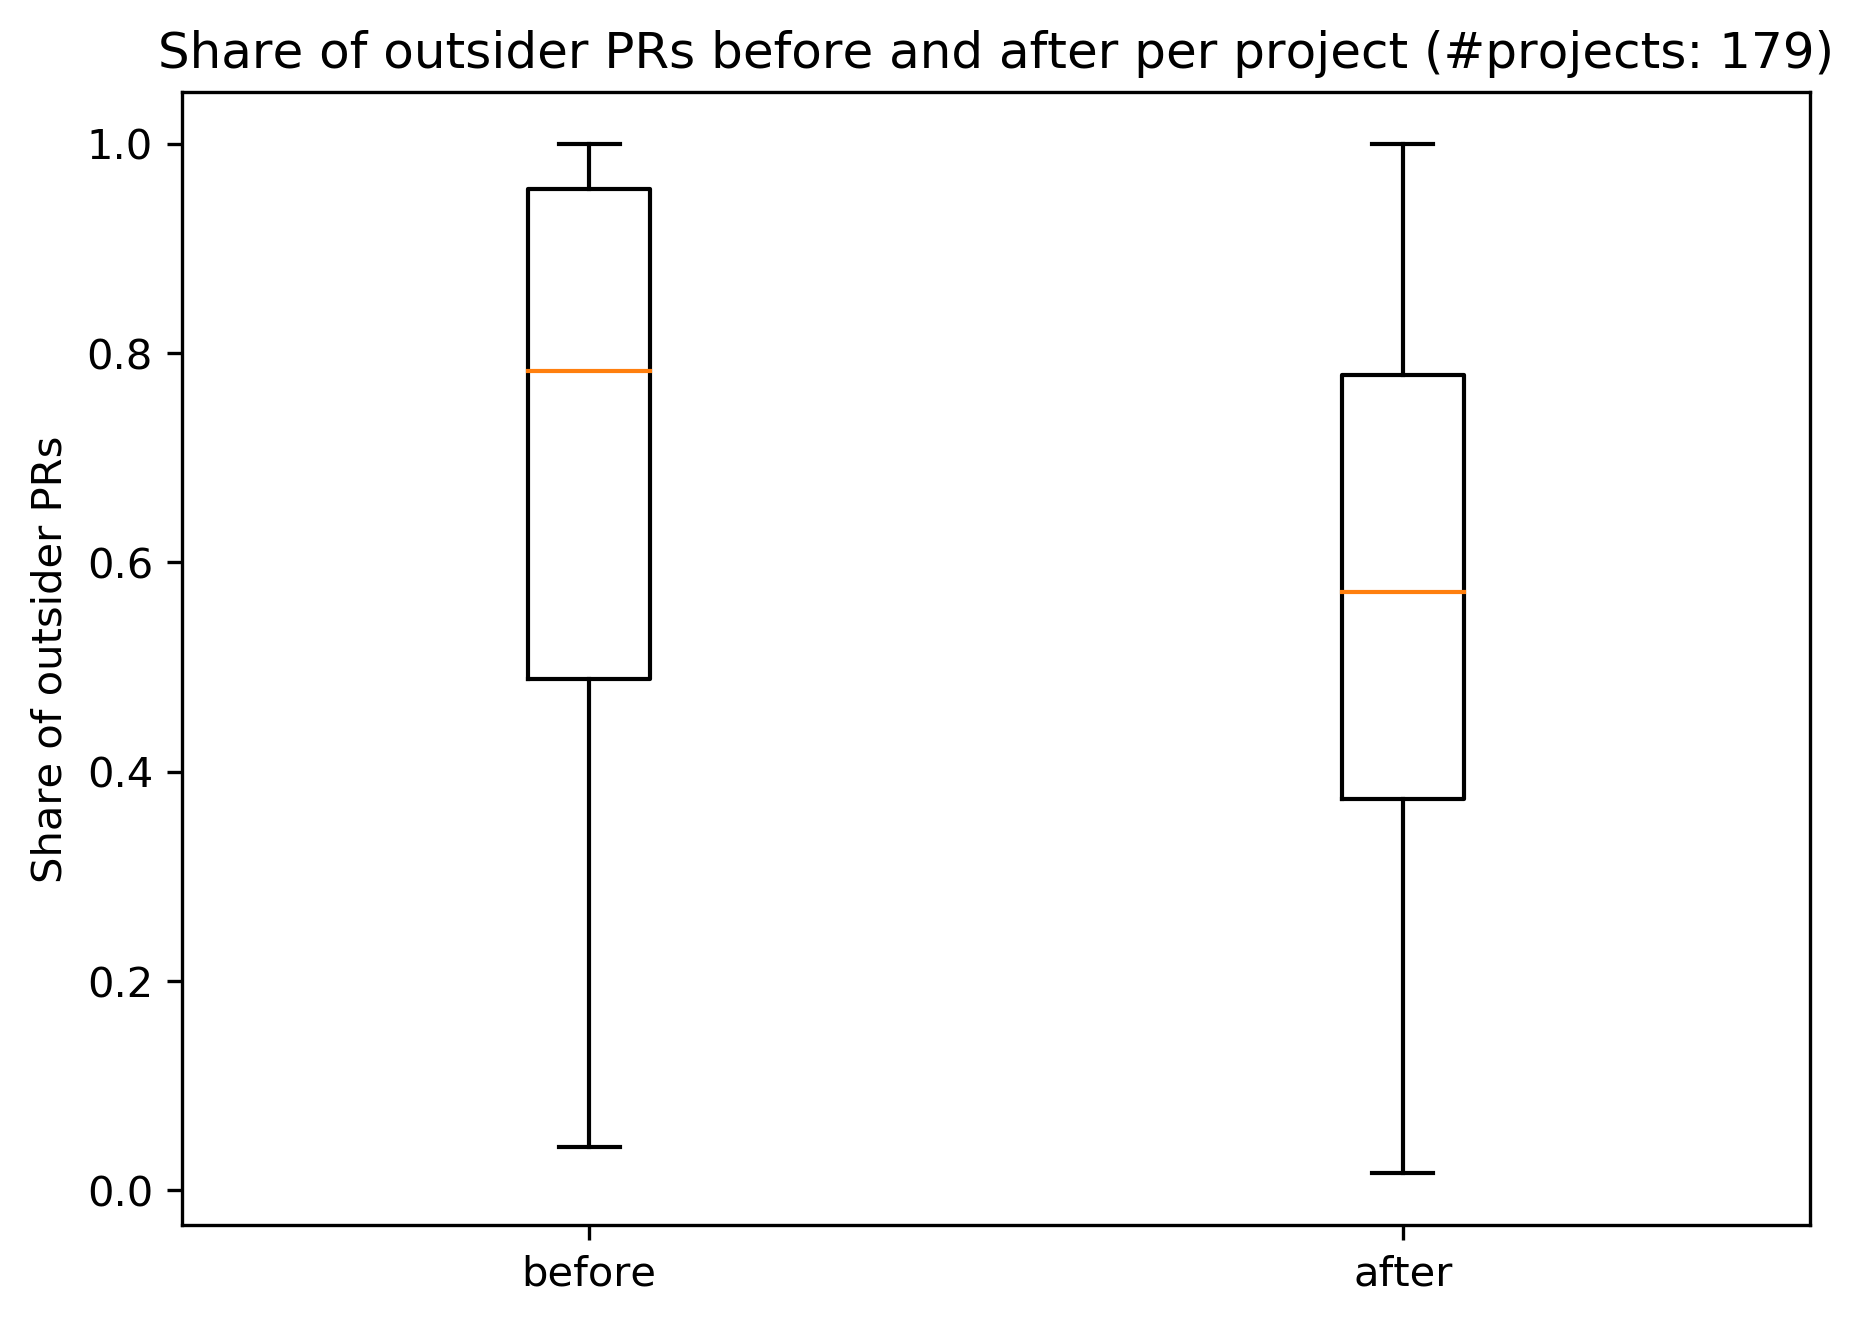

In [112]:
print("Skipped {} projects from the total {}".format(skipped, len(projects)))

plt.figure(figsize=(7,5))

plt.title("Share of outsider PRs before and after per project (#projects: {})".format(len(shares_outsider_before)))
plt.ylabel("Share of outsider PRs")

plt.boxplot([shares_outsider_before, shares_outsider_after])
plt.xticks(np.arange(2) + 1, ["before", "after"])

plt.show()

In [113]:
from scipy import stats

stats.wilcoxon(shares_outsider_before, shares_outsider_after, zero_method="wilcox")

WilcoxonResult(statistic=2594.0, pvalue=4.6364089239226607e-14)

## Before and after for the 3 predictors per project

For this plot all pull requests for one project are squashed into two buckets, one before and one after. The metrics computer are totals over these buckets. 

Skipped 54 projects from the total 233


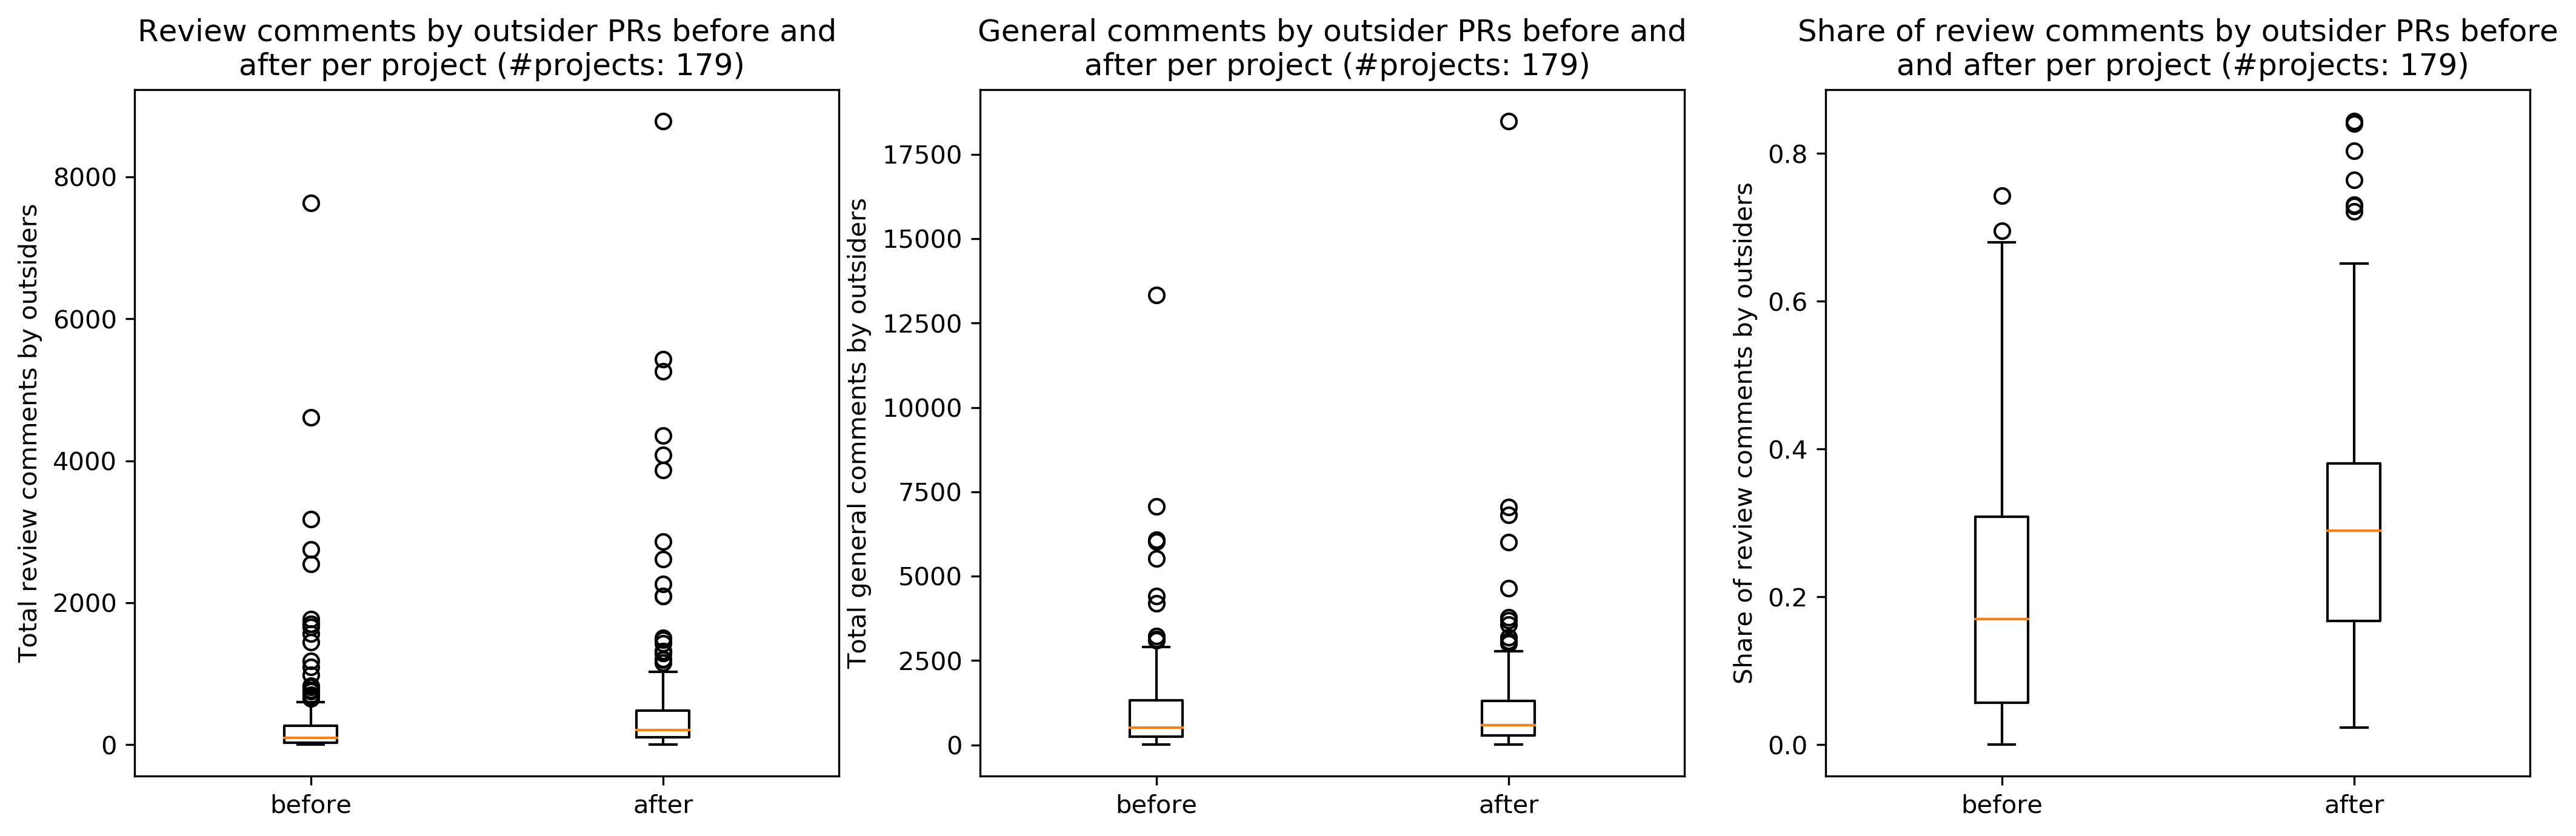

In [114]:
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

plt.rcParams['figure.dpi'] = 300
    
print("Skipped {} projects from the total {}".format(skipped, len(projects)))

plt.figure(figsize=(17,5))

ax = plt.subplot(1, 3, 1)

plt.title("Review comments by outsider PRs before and\n after per project (#projects: {})".
          format(len(total_review_comments_outsider_per_project_before)))
plt.ylabel("Total review comments by outsiders")

plt.boxplot([total_review_comments_outsider_per_project_before, total_review_comments_outsider_per_project_after])
plt.xticks(np.arange(2) + 1, ["before", "after"])

plt.subplot(1, 3, 2)

plt.title("General comments by outsider PRs before and\n after per project (#projects: {})".
          format(len(total_general_comments_outsider_pr_project_before)))
plt.ylabel("Total general comments by outsiders")

plt.boxplot([total_general_comments_outsider_pr_project_before, total_general_comments_outsider_pr_project_after])
plt.xticks(np.arange(2) + 1, ["before", "after"])

plt.subplot(1, 3, 3)

plt.title("Share of review comments by outsider PRs before\n and after per project (#projects: {})".
          format(len(share_review_comments_outsider_pr_project_before)))
plt.ylabel("Share of review comments by outsiders")

plt.boxplot([share_review_comments_outsider_pr_project_before, share_review_comments_outsider_pr_project_after])
plt.xticks(np.arange(2) + 1, ["before", "after"])

plt.show()

In [141]:
print("Review comments: ")
print(stats.wilcoxon(total_review_comments_outsider_per_project_before, total_review_comments_outsider_per_project_after, zero_method="wilcox"))

print("General comments: ")
print(stats.wilcoxon(total_general_comments_outsider_pr_project_before, total_general_comments_outsider_pr_project_after, zero_method="wilcox"))

print("Share of review comments: ")
print(stats.wilcoxon(share_review_comments_outsider_pr_project_before, share_review_comments_outsider_pr_project_after, zero_method="wilcox"))

Review comments: 
WilcoxonResult(statistic=3430.5, pvalue=1.3938316866135248e-14)
General comments: 
WilcoxonResult(statistic=7532.0, pvalue=0.013932532071665496)
Share of review comments: 
WilcoxonResult(statistic=3620.0, pvalue=8.996270777858147e-14)


## Before and after for the 3 predictors

For this plot each datapoint is one pull request. 

Skipped 58 projects from the total 249


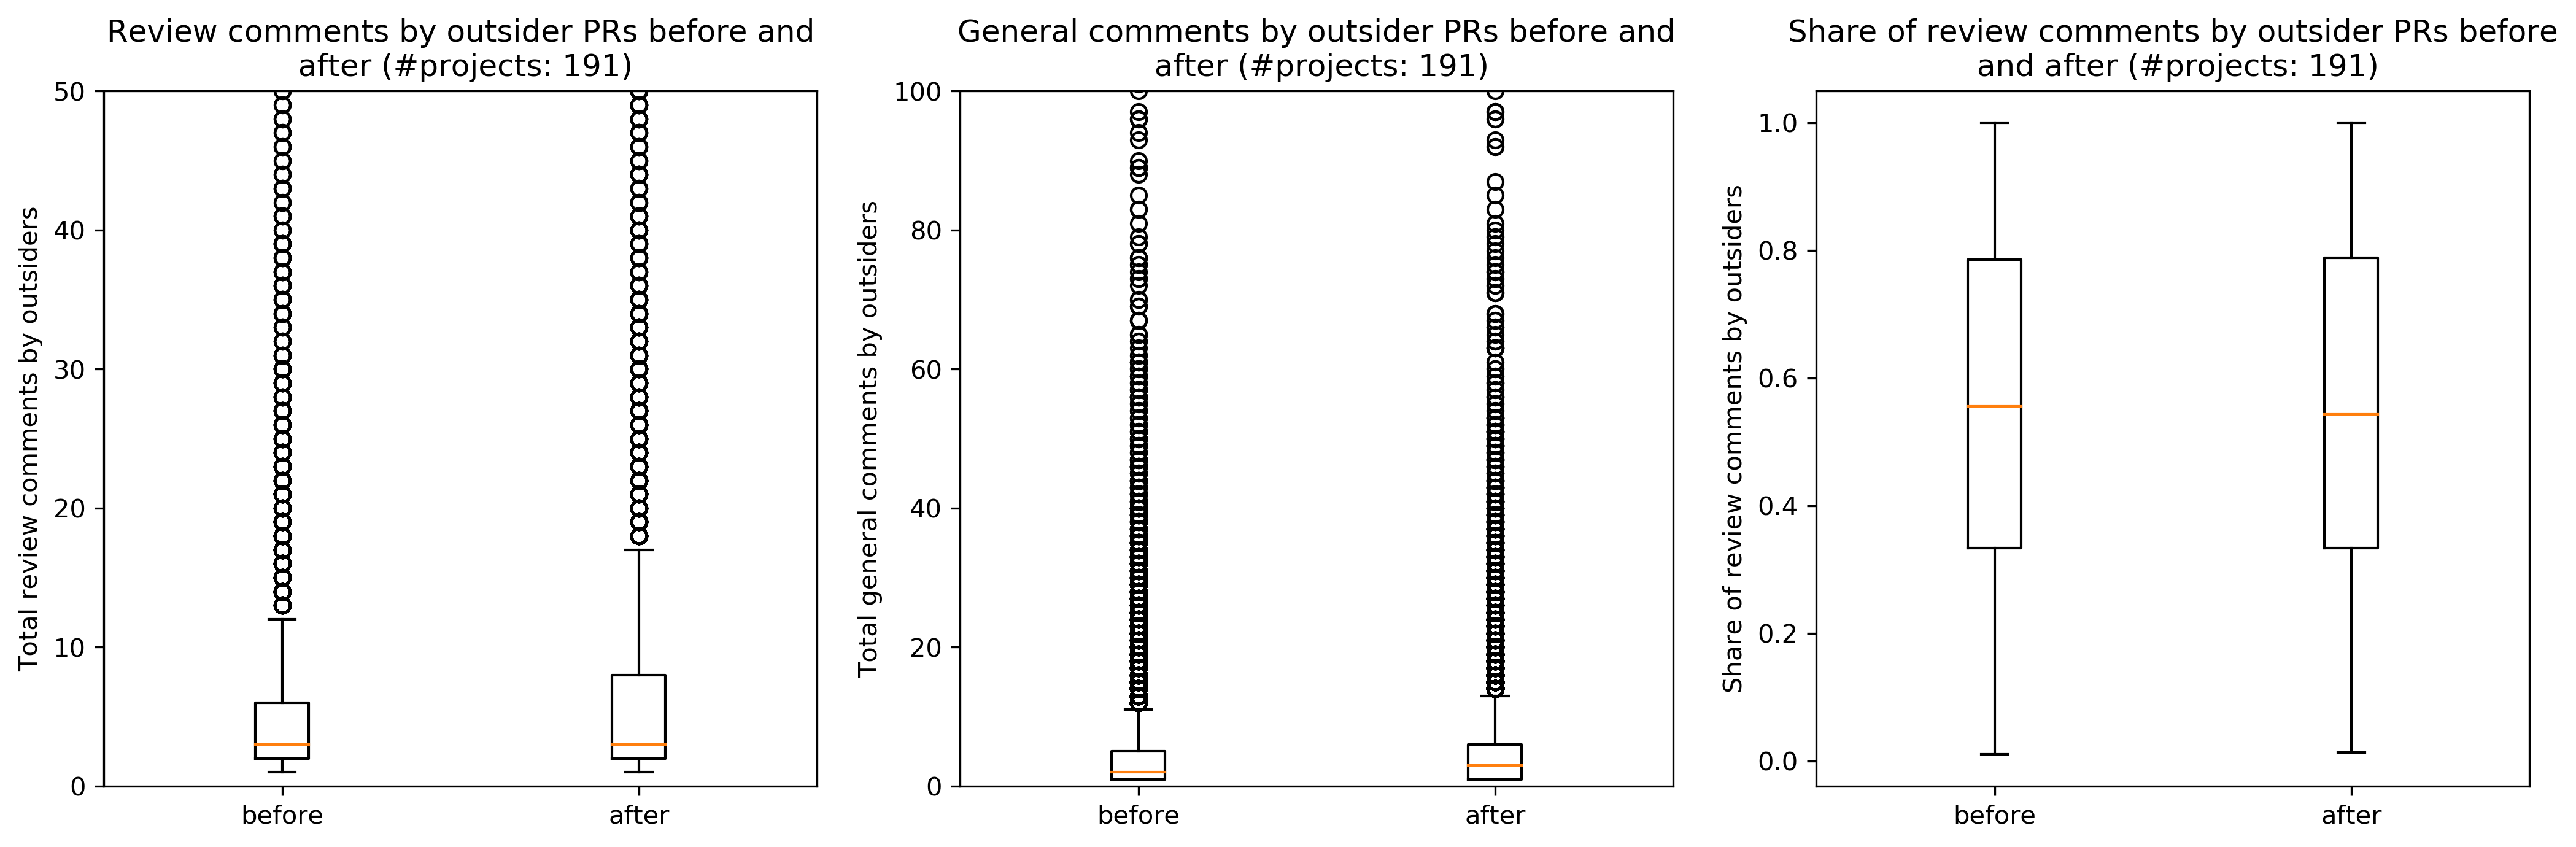

In [83]:
print("Skipped {} projects from the total {}".format(skipped, len(projects)))

plt.figure(figsize=(17,5))

ax = plt.subplot(1, 3, 1)

plt.title("Review comments by outsider PRs before and\n after (#projects: {})".
          format(len(projects) - skipped))
plt.ylabel("Total review comments by outsiders")

plt.boxplot([[n for n in review_comments_by_outsider_before if n > 0], [n for n in review_comments_by_outsider_after if n > 0]])
plt.xticks(np.arange(2) + 1, ["before", "after"])

plt.ylim(0,50)

plt.subplot(1, 3, 2)

plt.title("General comments by outsider PRs before and\n after (#projects: {})".
          format(len(projects) - skipped))
plt.ylabel("Total general comments by outsiders")

plt.boxplot([[n for n in general_comments_by_outsider_before if n > 0], [n for n in general_comments_by_outsider_after if n > 0]])
plt.xticks(np.arange(2) + 1, ["before", "after"])

plt.ylim(0,100)

plt.subplot(1, 3, 3)

plt.title("Share of review comments by outsider PRs before\n and after (#projects: {})".
          format(len(projects) - skipped))
plt.ylabel("Share of review comments by outsiders")

plt.boxplot([[p for p in share_review_comments_by_outsider_before_per_pr if p> 0], [p for p in share_review_comments_by_outsider_after_per_pr if p > 0]])
plt.xticks(np.arange(2) + 1, ["before", "after"])

plt.show()

## How is the ratio of review comments distributed

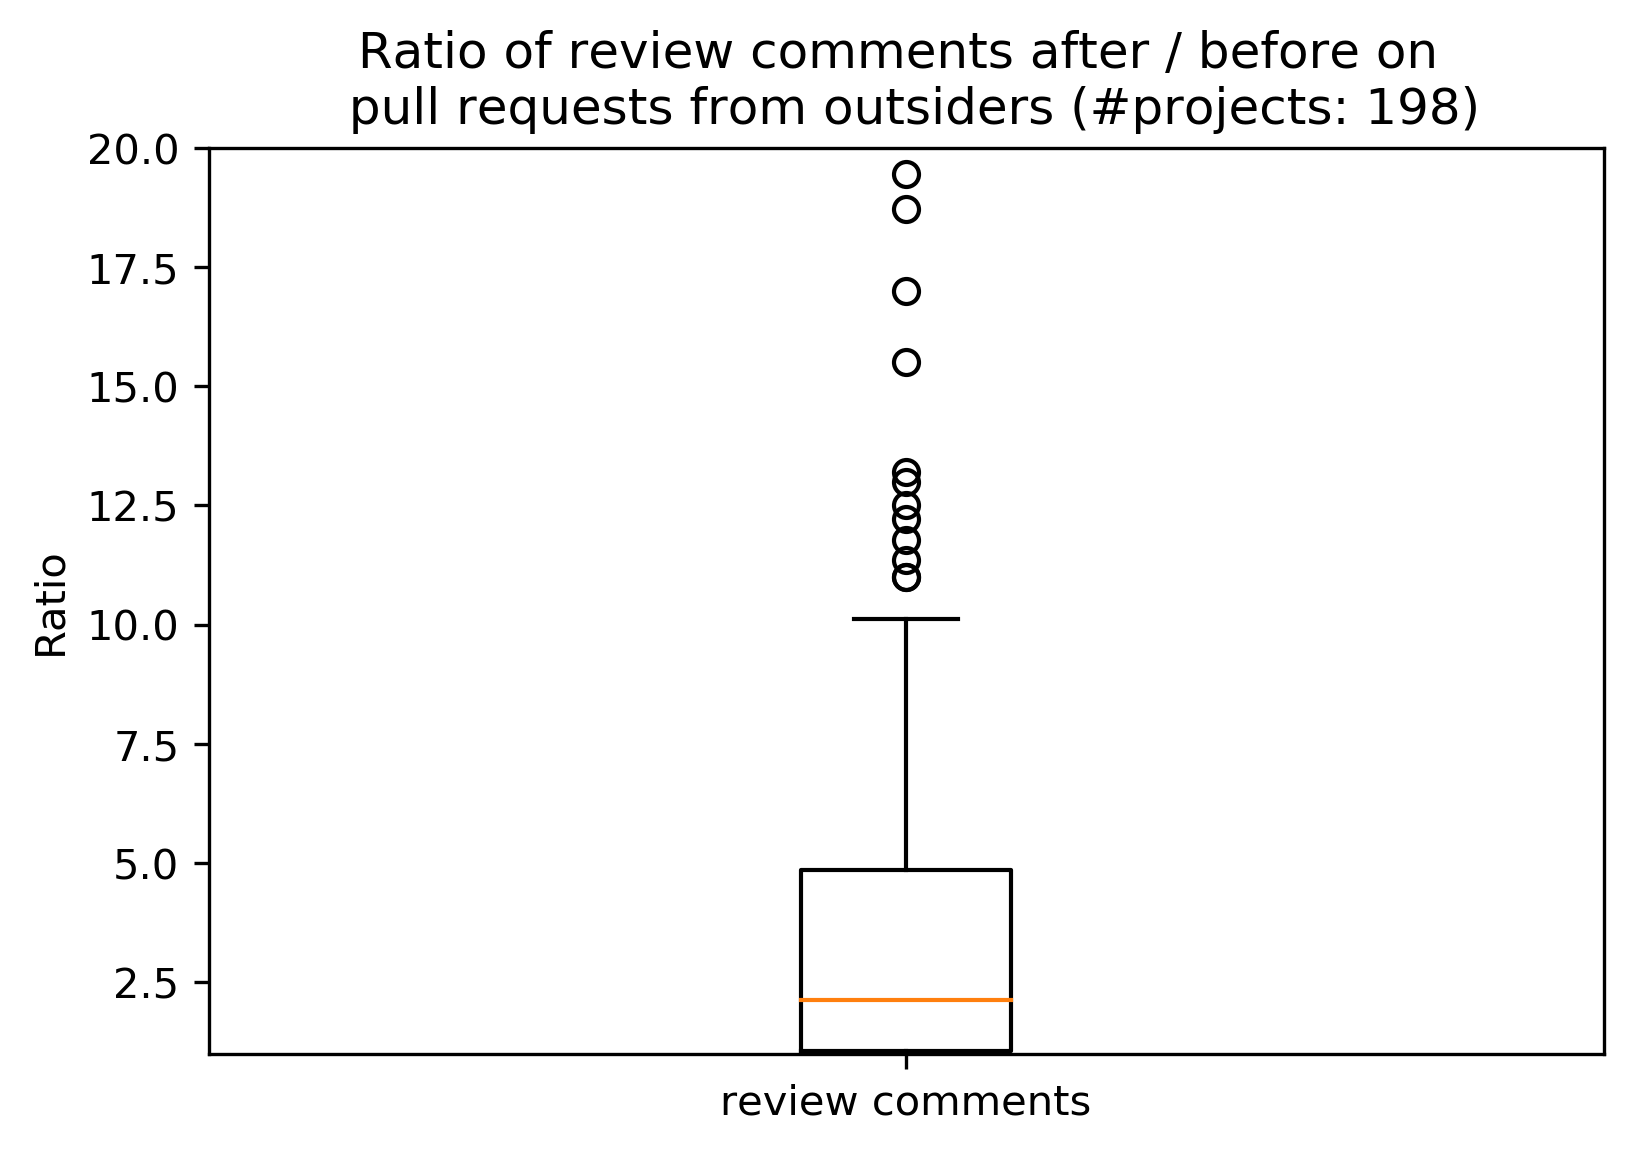

In [27]:
ratios = []

skipped = 0

import numpy as np

for i in range(len(total_review_comments_outsider_per_project_before)):
    
    if total_review_comments_outsider_per_project_after[i] == 0 or \
       total_review_comments_outsider_per_project_before[i] == 0:
        skipped += 1
        continue
    
    ratio = total_review_comments_outsider_per_project_after[i] / total_review_comments_outsider_per_project_before[i]
    
    ratios.append(ratio)
    
plt.title("Ratio of review comments after / before on \n pull requests from outsiders (#projects: {})".
          format(len(total_review_comments_outsider_per_project_before) - skipped))
plt.ylabel("Ratio")

plt.boxplot([ratios])
plt.xticks(np.arange(1) + 1, ["review comments"])

plt.ylim((1,20))

plt.show()




# Time series

In [12]:
from datetime import datetime, timedelta
   
period = 30
periods = 24

metrics = [[] for x in range(periods + 1)]

for project in projects:
    project_names.append(project["full_name"])
    
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))
    
    #prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, True)
    
    travis_date = project["status_travis_date"]
    
    start_date = travis_date - timedelta(days=period/2 + period*(periods/2))
    
    empty_period = False
    
    split_prs = []
    
    for i in range(periods + 1):
        end_date = start_date + timedelta(days=period)
        
        prs_in_period = []
        
        for pr in prs:
            if pr["created_at"] > start_date and pr["created_at"] < end_date:
                prs_in_period.append(pr)
                
        if len(prs_in_period) == 0:
            empty_period = True
            break
            
        split_prs.append(prs_in_period)
            
        start_date = end_date
        
    if empty_period:
        continue
    
    print("{} is valid".format(project["full_name"]))
    
    for i in range(len(split_prs)):
        prs_in_period = split_prs[i]
        
        total_review_comments = sum([len(pr["review_comments"]) for pr in prs_in_period])
        total_general_comments = sum([len(pr["raw_comments"]) for pr in prs_in_period])

        total = total_review_comments + total_general_comments   
        
        if total == 0:
            share_review_comments = 0
        else: 
            share_review_comments = total_review_comments / total
        
      
        metrics[i].append(share_review_comments)
    

Leaflet/Leaflet is valid
MarkUsProject/Markus is valid
NancyFx/Nancy is valid
OP2/PyOP2 is valid
OPM/opm-core is valid
OPM/opm-parser is valid
RestKit/RestKit is valid
Smoothieware/Smoothieware is valid
AFNetworking/AFNetworking is valid
Theano/Theano is valid
PCSX2/pcsx2 is valid
PX4/Firmware is valid
antlr/antlr4 is valid
PecanProject/pecan is valid
Pylons/pyramid is valid
GoldenCheetah/GoldenCheetah is valid
AnalyticalGraphicsInc/cesium is valid
Automattic/_s is valid
Azure/azure-sdk-for-node is valid
IQSS/dataverse is valid
ImageEngine/cortex is valid
ReactiveX/RxJava is valid
TrinityCore/TrinityCore is valid
apache/storm is valid
appcelerator/alloy is valid
BabylonJS/Babylon.js is valid
UniversalMediaServer/UniversalMediaServer is valid
appcelerator/titanium_mobile is valid
KSP-KOS/KOS is valid
aquynh/capstone is valid
astaxie/beego is valid
boto/boto is valid
astropy/astropy is valid
buildbot/buildbot is valid
WoltLab/WCF is valid
Zarel/Pokemon-Showdown is valid
cakephp/cakephp i

126


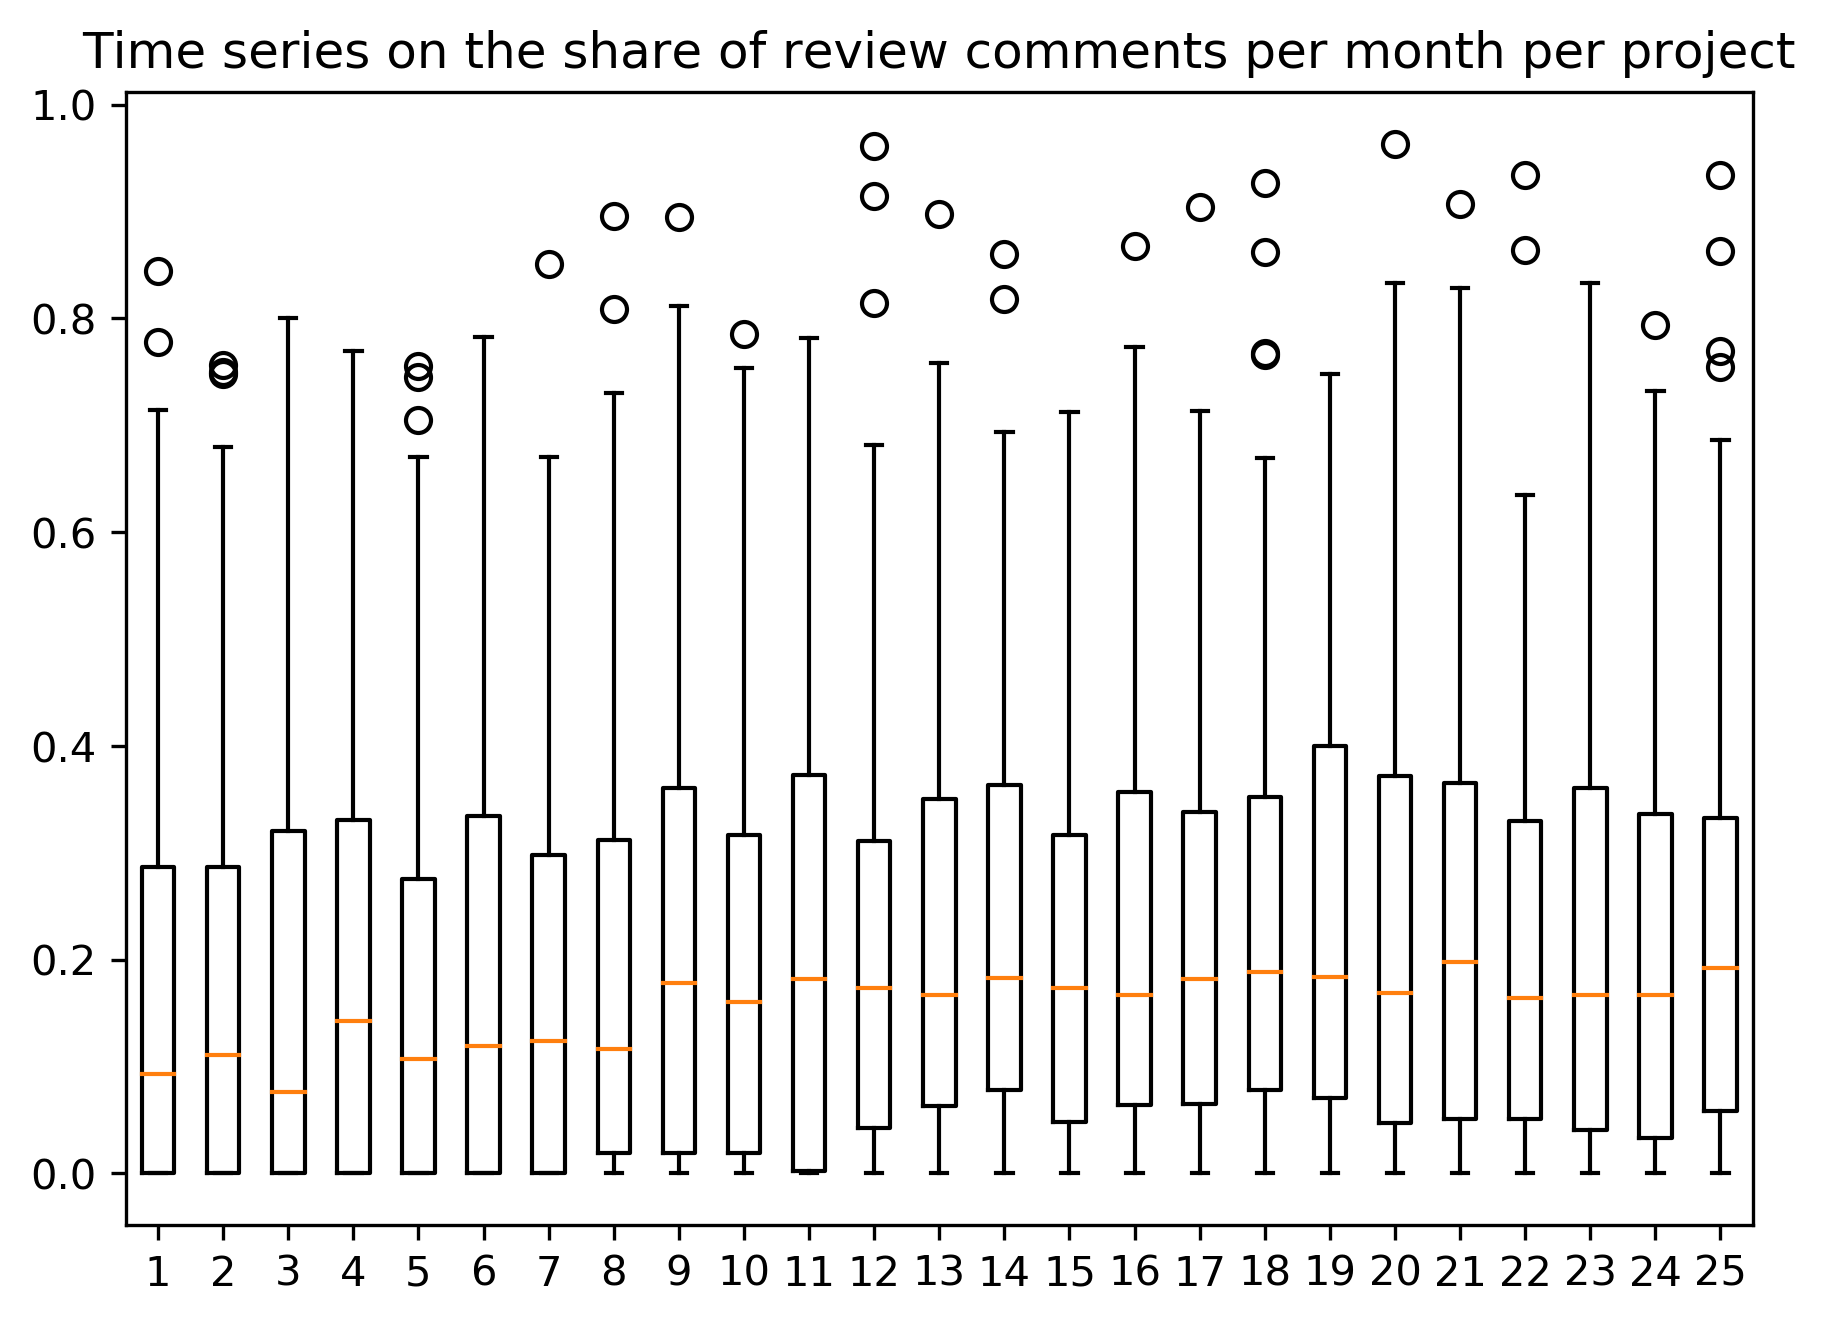

In [18]:
plt.figure(figsize=(7,5))

print(len(metrics[0]))

plt.boxplot(metrics)

plt.title("Time series on the share of review comments per month per project")

plt.show()

In [14]:
def calculate_share_review_comments(prs, project):
    total_review_comments = sum([len(pr["review_comments"]) for pr in prs])
    total_general_comments = sum([len(pr["raw_comments"]) for pr in prs])

    total = total_review_comments + total_general_comments   

    if total == 0:
        share_review_comments = 0
    else: 
        share_review_comments = total_review_comments / total
        
    return share_review_comments

def project_name(prs, project):
    return project["full_name"]

def sum_field(fieldname, is_list = False):
    def sum_field_func(prs, project):
        if is_list:
            return sum([len(pr[fieldname]) for pr in prs])
        else:
            return sum([pr[fieldname] for pr in prs])
        
    return sum_field_func

def total_prs(prs, project):
    return len(prs)

def project_language(prs, project):
    return project["language"]
    
metrics_to_calculate = [
    {'Name': 'ProjectName', 'Func': project_name},
    {'Name': 'Language', 'Func': project_language},
    {'Name': 'ShareReviewComments', 'Func': calculate_share_review_comments},
    {'Name': 'Additions', 'Func': sum_field("additions")},
    {'Name': 'Deletions', 'Func': sum_field("deletions")},
    {'Name': 'ChangedFiles', 'Func': sum_field("changed_files")},
    {'Name': 'Assignees', 'Func': sum_field("assignees", True) },
    {'Name': 'ReviewComments', 'Func': sum_field("review_comments", True)},
    {'Name': 'GeneralComments', 'Func': sum_field("raw_comments", True)},
    {'Name': 'TotalPrs', 'Func': total_prs},
    {'Name': 'Commits', 'Func': sum_field("commits", True)}
]

In [15]:
from datetime import datetime, timedelta
   
period = 30
periods = 24

metric_collection = {}

filename = "generated/metrics_for_time_series.csv"

for metric in metrics_to_calculate:
    metric_collection[metric["Name"]] = [[] for x in range(periods + 1)]



for project in projects:
    project_names.append(project["full_name"])

    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))

    #prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, True)

    travis_date = project["status_travis_date"]

    start_date = travis_date - timedelta(days=period/2 + period*(periods/2))

    empty_period = False

    split_prs = []

    for i in range(periods + 1):
        end_date = start_date + timedelta(days=period)

        prs_in_period = []

        for pr in prs:
            if pr["created_at"] > start_date and pr["created_at"] < end_date:
                prs_in_period.append(pr)

        if len(prs_in_period) == 0:
            empty_period = True
            break

        split_prs.append(prs_in_period)

        start_date = end_date

    if empty_period:
        continue

    for i in range(len(split_prs)):
        prs_in_period = split_prs[i]

        for metric in metrics_to_calculate:
            metric_collection[metric["Name"]][i].append(metric["Func"](prs_in_period, project))


        

In [16]:
with open(filename, mode='w') as time_series_file:
    writer = csv.writer(time_series_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    writer.writerow([metric["Name"] for metric in metrics_to_calculate] + ["Period"])
    
    for j in range(len(metric_collection[metrics_to_calculate[0]["Name"]])):
        for i in range(periods + 1):
            metric_names = [metric["Name"] for metric in metrics_to_calculate]

            line_to_write = [metric_collection[metric][i][j] for metric in metric_names] + [i + 1]

            writer.writerow(line_to_write)

# Data collection validity

Does the order in which projects have been added affect the significance of doing the statistical tests?

We determine this by adding a project one at a time to see if the $p$ value converges. To ensure that no funny business happens we pick the same set of pull requests for aggregation.

In [3]:
from scipy import stats
from collections import Counter

#The below arrays are all for per project aggregations:
shares_outsider_before = []
shares_outsider_after = []

total_review_comments_outsider_per_project_before = []
total_review_comments_outsider_per_project_after = []

total_general_comments_outsider_pr_project_before = []
total_general_comments_outsider_pr_project_after = []

share_review_comments_outsider_pr_project_before = []
share_review_comments_outsider_pr_project_after = []

#The below arrays do not bunch projects up pe
review_comments_by_outsider_before = []
review_comments_by_outsider_after = []

general_comments_by_outsider_before = []
general_comments_by_outsider_after = []

share_review_comments_by_outsider_before_per_pr = []
share_review_comments_by_outsider_after_per_pr = []

pvals_general_grouped = []

prs_per_project = []

skipped = 0

language_counts = Counter()

series = {}

series["pvals"] = []
series["prs"] = []

for project in projects:
    language_counts[project["language"]] += 1

i = 0
    
for lang in language_counts.most_common(7):
    series["pvals"].append({'lang':lang[0], 'x':[],'y':[]})
    series["prs"].append({'lang':lang[0], 'x':[],'y':[]})
    
series["pvals"].append({'lang':'other', 'x':[],'y':[]})
series["prs"].append({'lang':'other', 'x':[],'y':[]})
    
for project in projects:

    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))

    prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, True)#, seed=57662347)

    if len(prs_before) < 100 or len(prs_after) < 100:
        skipped += 1
        continue

    # Do shares outsider

    total_outsider_before = sum([1 for pr in prs_before if pr["from_outsider"]])
    total_insider_before = sum([1 for pr in prs_before if not pr["from_outsider"]])

    total_before = total_outsider_before + total_insider_before    

    total_insider_after = sum([1 for pr in prs_after if not pr["from_outsider"]])
    total_outsider_after = sum([1 for pr in prs_after if pr["from_outsider"]])

    total_after = total_insider_after + total_outsider_after

    if total_before == 0 or total_after == 0:
        skipped += 1
        continue

    share_outsider_before = total_outsider_before / total_before
    share_outsider_after = total_outsider_after / total_after

    shares_outsider_before.append(share_outsider_before)
    shares_outsider_after.append(share_outsider_after)

    #Do review comments outsiders
    review_comments_by_outsider_before += [len(pr["review_comments"]) for pr in prs_before if pr["from_outsider"]]
    review_comments_by_outsider_after += [len(pr["review_comments"]) for pr in prs_after if pr["from_outsider"]]    

    total_review_comments_by_outsiders_before = sum([len(pr["review_comments"]) for pr in prs_before if pr["from_outsider"]])
    total_review_comments_by_outsiders_after = sum([len(pr["review_comments"]) for pr in prs_after if pr["from_outsider"]])

    total_review_comments_outsider_per_project_before.append(total_review_comments_by_outsiders_before)
    total_review_comments_outsider_per_project_after.append(total_review_comments_by_outsiders_after)

    #Do general comments by outsiders
    general_comments_by_outsider_before += [len(pr["raw_comments"]) for pr in prs_before if pr["from_outsider"]]
    general_comments_by_outsider_after += [len(pr["raw_comments"]) for pr in prs_after if pr["from_outsider"]]

    total_general_comments_by_outsiders_before = sum([len(pr["raw_comments"]) for pr in prs_before if pr["from_outsider"]])
    total_general_comments_by_outsiders_after = sum([len(pr["raw_comments"]) for pr in prs_after if pr["from_outsider"]])

    total_general_comments_outsider_pr_project_before.append(total_general_comments_by_outsiders_before)
    total_general_comments_outsider_pr_project_after.append(total_general_comments_by_outsiders_after)

    #Do share of review comments by outsiders
    def do_prs_share_calc(prs, target):
        for pr in prs:
            n_raw_comments = len(pr["raw_comments"])
            n_review_comments = len(pr["review_comments"])

            total_comments = n_raw_comments+n_review_comments

            if total_comments == 0:
                target.append(0)
            else:
                target.append(n_review_comments / total_comments)

    do_prs_share_calc(prs_before, share_review_comments_by_outsider_before_per_pr)
    do_prs_share_calc(prs_after, share_review_comments_by_outsider_after_per_pr)

    share_review_comments_by_outsider_before = total_review_comments_by_outsiders_before / \
                                    (total_review_comments_by_outsiders_before + total_general_comments_by_outsiders_before)

    share_review_comments_by_outsider_after = total_review_comments_by_outsiders_after / \
                                    (total_review_comments_by_outsiders_after + total_general_comments_by_outsiders_after)

    share_review_comments_outsider_pr_project_before.append(share_review_comments_by_outsider_before)
    share_review_comments_outsider_pr_project_after.append(share_review_comments_by_outsider_after)
    
    pval = stats.wilcoxon(total_general_comments_outsider_pr_project_before, total_general_comments_outsider_pr_project_after, zero_method="wilcox").pvalue
    
    i += 1
    
    if project["language"] in [item["lang"] for item in series["pvals"]]:
        target = [item for item in series["pvals"] if item["lang"] == project["language"]][0]
    else:
        target = [item for item in series["pvals"] if item["lang"] == 'other'][0]
        
    target["x"].append(i)
    target["y"].append(pval)
    
    if project["language"] in [item["lang"] for item in series["prs"]]:
        target = [item for item in series["prs"] if item["lang"] == project["language"]][0]
    else:
        target = [item for item in series["prs"] if item["lang"] == 'other'][0]
        
    target["x"].append(i)
    target["y"].append(len(prs))
         

/home/nathancassee/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/home/nathancassee/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/home/nathancassee/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/home/nathancassee/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/home/nathancassee/anaconda3/lib/python3.6/site-packages/scipy/s

KeyError: 'from_outsider'

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300

print(language_counts.most_common(10))

plt.figure(figsize=(8,5))

for serie in series["pvals"]:
    plt.scatter(serie["x"], serie["y"], s = 6, label=serie["lang"])
    
plt.legend()
    
plt.ylabel("$p$ value")
plt.xlabel("Number of projects")
plt.title("Effect of adding more projects to the Wilcoxon test \nfor the number of general comments before and after")
plt.ylim((0, 1))

#print("Final p value is {}".format(pvals_general_grouped[-1]))

plt.show()

In [ ]:
import matplotlib.pyplot as plt

x_vals = [i + 1 for i in range(len(prs_per_project))]

plt.rcParams['figure.dpi'] = 300

plt.figure(figsize=(8,5))

for serie in series["prs"]:
    plt.scatter(serie["x"], serie["y"], s = 5, label=serie["lang"])
    
plt.legend()
plt.ylabel("Number of pull requests")
plt.xlabel("Number of projects")
plt.title("The size of projects in the order they have been added")
#plt.ylim((0, 1))

plt.show()